In [1]:
import numpy as np

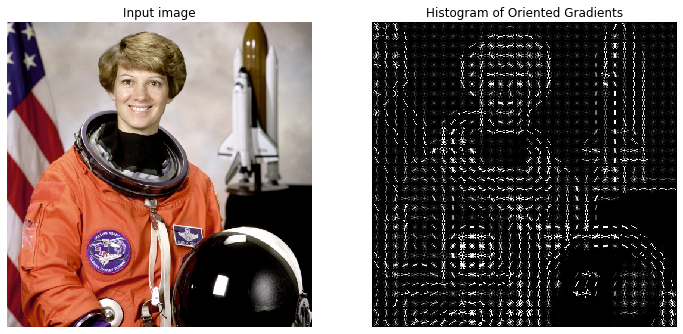

In [2]:
# Example code given in Scikit-Image's docs 

%matplotlib inline
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [3]:
#positive set of labbeled people in the wild 

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape ## 13233 face images to use for training

(13233, 62, 47)

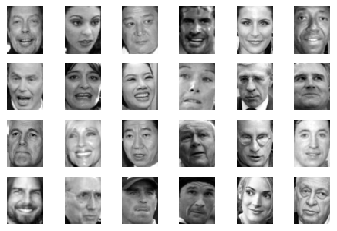

In [4]:
# Visualize Positive Set (face images)

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

In [5]:
# negative set
from skimage import data, transform, color

imgs_to_use = ['hubble_deep_field', 'text', 'coins', 'moon',
               'page', 'clock','coffee','chelsea','horse']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [6]:
# To make up the negative set we extract patches from images shipped
# with Scikit-Image at various scales 
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape  # 27000 images for negative set

(27000, 62, 47)

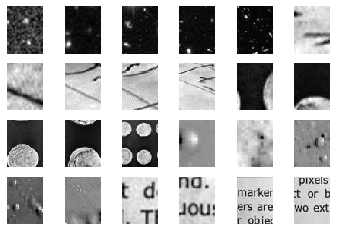

In [7]:
# Visualize Negative Set
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[600 * i], cmap='gray')
    axi.axis('off')

In [8]:
# combine positive and negative sets and extract hog features

from skimage import feature   # To use skimage.feature.hog()
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
# Training a SVM classifier.
# We do gridsearch over some choices SVM's C parameter to get best result

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9874978251683941

In [10]:
grid.best_params_ 

{'C': 1.0}

In [11]:
# Taking the best estimator and train it on full dataset

model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

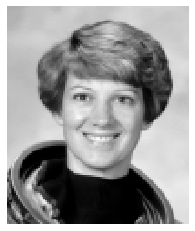

In [13]:
# Detect Faces in a New Image

test_img = data.astronaut()
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [14]:
# Sliding Window function - Goes Over the image patch by patch
# and computes the HOG features for each patch.


def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [15]:
# Apply sliding window function to test_img

indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(551, 1215)

In [16]:
# Use the model to evaluate if HOG patches of the image
# contains a face
labels = model.predict(patches_hog)
labels.sum() # number of face detections from all the patches in the image

54.0

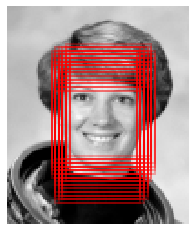

In [17]:
# Visualize the detections

fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))